# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [2]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [3]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [4]:
# Dimension
dim = 2

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 50

# Number of samples from the solution we have access to
data_points = 500

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [5]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# Example: Visualize the target convex and prior functions in 2D

Text(0, 0.5, 'prior_true($x_2$,0)')

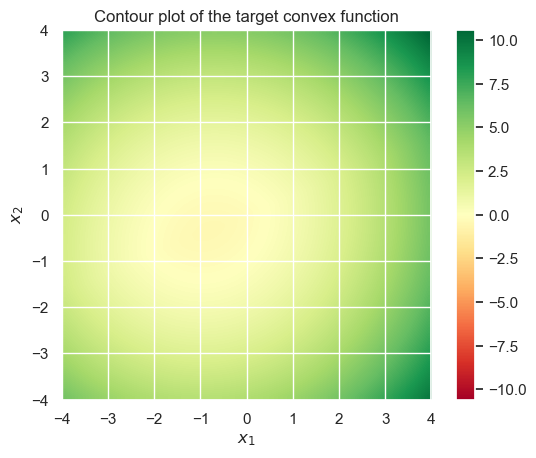

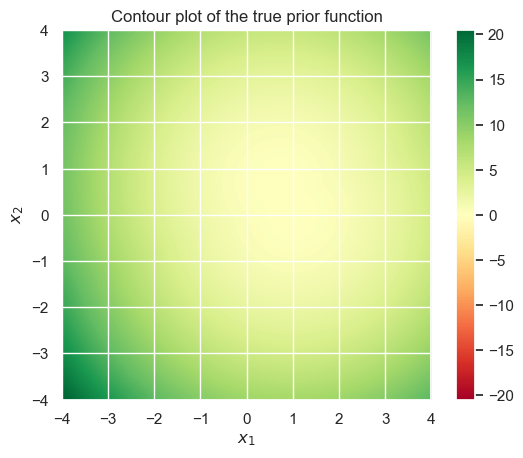

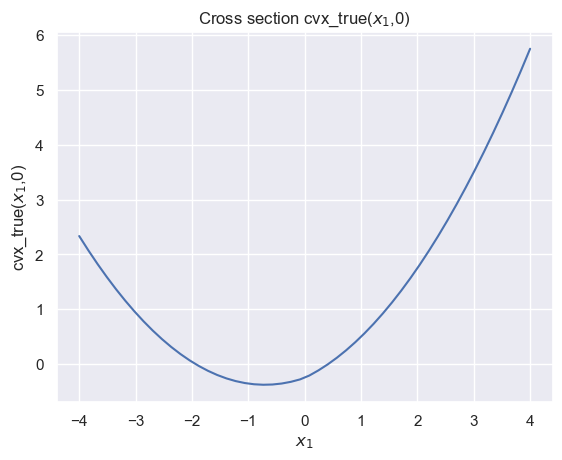

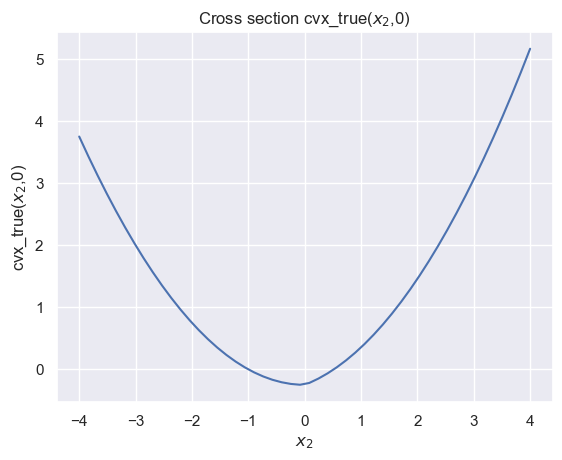

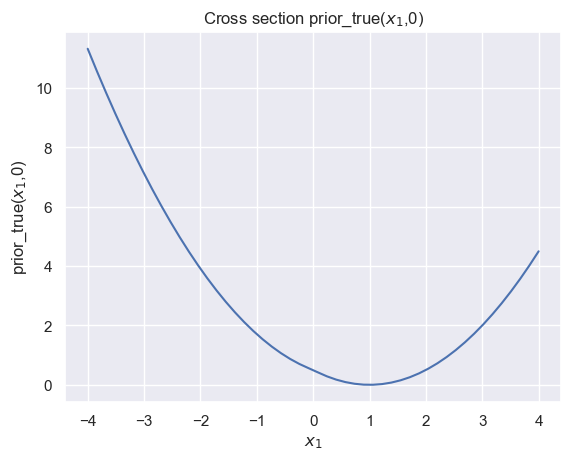

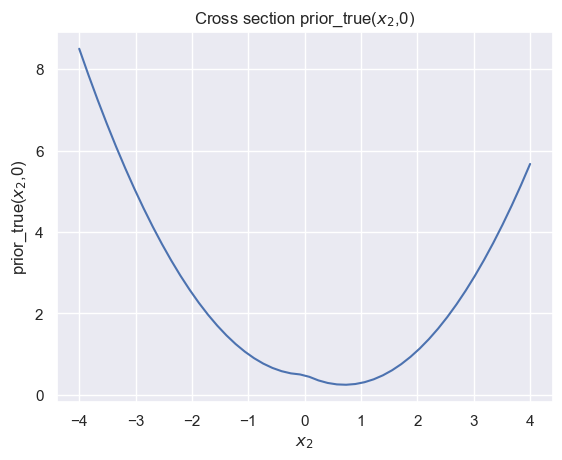

In [6]:
# Generate a square [-a, a]^{2} square meshgrid and recover the list of points
xi = np.linspace(-a,a,spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Training function

In [7]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [8]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 9.283331871032715
iteration 0 loss 124.92648315429688
iteration 500 loss 1.9553935527801514
iteration 1000 loss 0.7213718295097351
iteration 1500 loss 0.6186625957489014
iteration 2000 loss 0.5631558895111084
iteration 2500 loss 0.49384307861328125
iteration 3000 loss 0.40819957852363586
iteration 3500 loss 0.31035664677619934
iteration 4000 loss 0.21186968684196472
iteration 4500 loss 0.1239125207066536
iteration 5000 loss 0.06354042887687683
iteration 5500 loss 0.03128264471888542
iteration 6000 loss 0.01763020269572735
iteration 6500 loss 0.011271998286247253
iteration 7000 loss 0.007527418900281191
iteration 7500 loss 0.005350222811102867
iteration 8000 loss 0.0039883991703391075
iteration 8500 loss 0.0030033783987164497
iteration 9000 loss 0.0022865845821797848
iteration 9500 loss 0.0017328629037365317
iteration 10000 loss 0.0013099792413413525
iteration 10500 loss 0.0009837972465902567
iteration 11000 loss 0.0007311737863346934
iteration 11500 loss 0.000540664885

L2 loss -- Plot

loss -11.24683952331543
loss -58.98776626586914
loss -98.24116516113281
loss -131.1637725830078
loss -159.33497619628906
loss -183.574462890625
loss -204.02459716796875
loss -220.97622680664062
loss -235.15850830078125
loss -246.98367309570312
loss -256.4131774902344
loss -263.9479675292969
loss -270.2831115722656
loss -275.9541015625
loss -281.38226318359375
loss -286.7884826660156
loss -292.27313232421875
loss -297.872802734375
loss -303.58148193359375
loss -309.37738037109375
loss -315.23602294921875
loss -321.13525390625
loss -327.05792236328125
loss -332.99163818359375
loss -338.9276123046875
loss -344.85943603515625
loss -350.78265380859375
loss -356.6943359375
loss -362.59228515625
loss -368.47637939453125
loss -374.3479919433594
loss -380.2080078125
loss -386.0574951171875
loss -391.89666748046875
loss -397.7254638671875
loss -403.541748046875
loss -409.34759521484375
loss -415.14288330078125
loss -420.927001953125
loss -426.701904296875
final mse:  0.11955168098211288
max, min

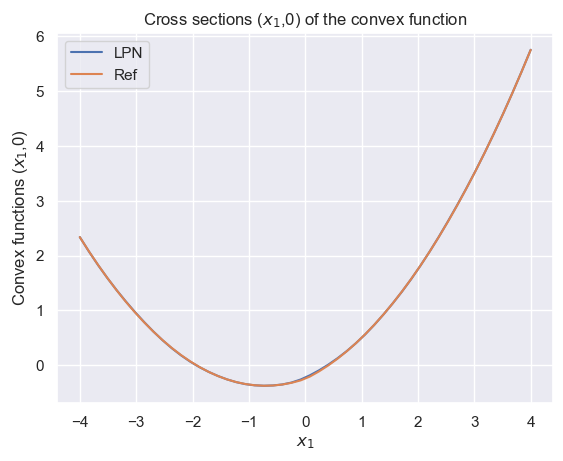

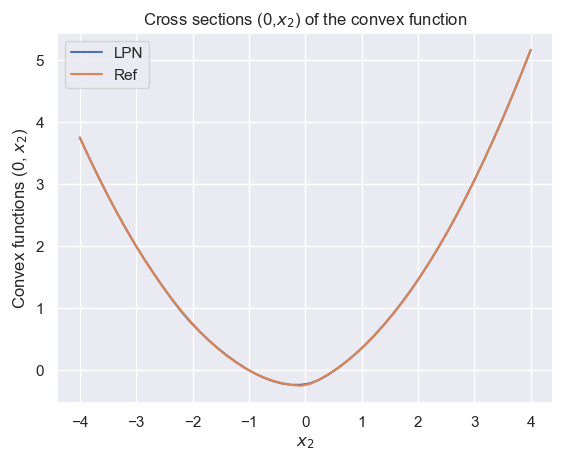

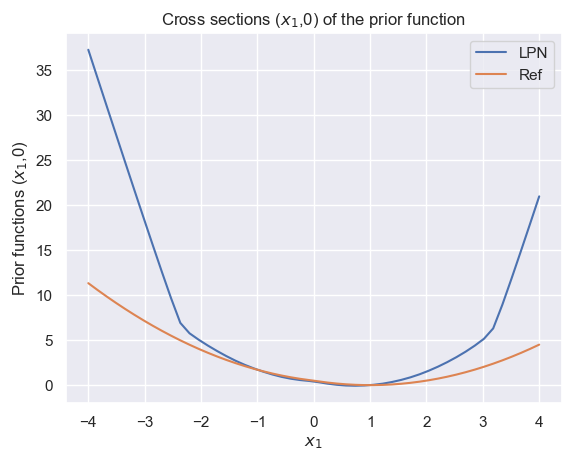

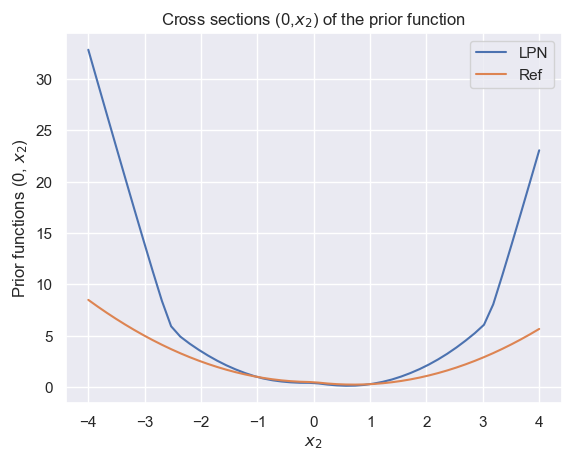

In [9]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

L1 loss -- Train

In [10]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

iteration 0 loss 3.460376262664795
iteration 0 loss 9.55994701385498
iteration 500 loss 0.649909496307373
iteration 1000 loss 0.46246573328971863
iteration 1500 loss 0.26957738399505615
iteration 2000 loss 0.14643187820911407
iteration 2500 loss 0.06492626667022705
iteration 3000 loss 0.02385783940553665
iteration 3500 loss 0.016427630558609962
iteration 4000 loss 0.0134880430996418
iteration 4500 loss 0.011379503645002842
iteration 5000 loss 0.009710945188999176
iteration 5500 loss 0.008822213858366013
iteration 6000 loss 0.008219593204557896
iteration 6500 loss 0.007748091593384743
iteration 7000 loss 0.006829224061220884
iteration 7500 loss 0.007433849852532148
iteration 8000 loss 0.007087661884725094
iteration 8500 loss 0.006942370906472206
iteration 9000 loss 0.0068127731792628765
iteration 9500 loss 0.005780251696705818
iteration 10000 loss 0.005836569704115391
iteration 10500 loss 0.006709837820380926
iteration 11000 loss 0.006068866699934006
iteration 11500 loss 0.0051767737604

L1 loss -- Plot

loss -10.79896354675293
loss -58.49879455566406
loss -98.14139556884766
loss -131.633544921875
loss -160.32919311523438
loss -183.99276733398438
loss -204.0440673828125
loss -220.997802734375
loss -235.26272583007812
loss -247.15582275390625
loss -256.9523010253906
loss -264.9684753417969
loss -272.1068115234375
loss -278.9321594238281
loss -285.7033996582031
loss -292.5479736328125
loss -299.5165710449219
loss -306.61248779296875
loss -313.8161315917969
loss -321.10052490234375
loss -328.440673828125
loss -335.8164367675781
loss -343.21356201171875
loss -350.62225341796875
loss -358.034912109375
loss -365.44732666015625
loss -372.8560485839844
loss -380.2597961425781
loss -387.6568908691406
loss -395.0477294921875
loss -402.43109130859375
loss -409.80731201171875
loss -417.1762390136719
loss -424.5384216308594
loss -431.8956298828125
loss -439.2490234375
loss -446.5986328125
loss -453.9451904296875
loss -461.2889709472656
loss -468.630126953125
final mse:  0.17065252363681793
max, min

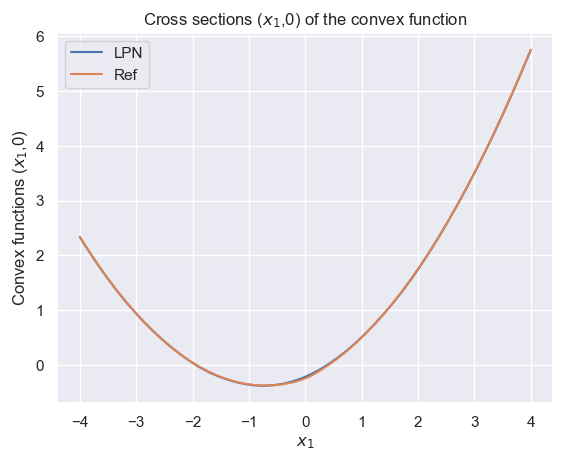

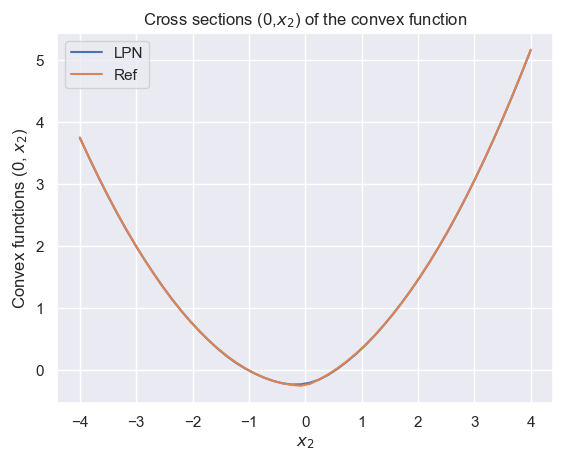

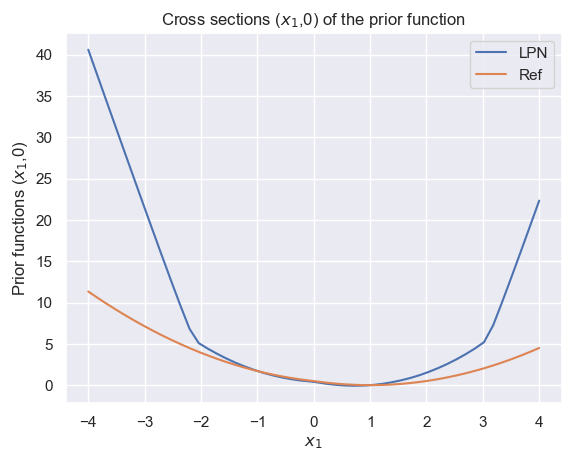

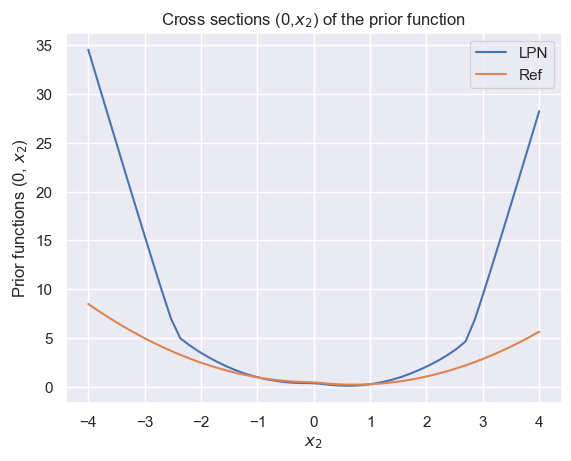

In [11]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [12]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [13]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [14]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [15]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [16]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [17]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)